In [91]:
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import xgboost as xgb
import math

from pandas.plotting import scatter_matrix
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

sns.set()
%matplotlib inline

In [93]:
from sklearn.neighbors import KNeighborsRegressor

In [95]:
insurance_df = pd.read_csv(r"C:\Users\Dell\Data_Science\Data\insurance.csv")

In [97]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [99]:
insurance_df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [101]:
insurance_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [103]:
insurance_df.duplicated().sum()

1

In [105]:
duplicates = insurance_df[insurance_df.duplicated()]
print(duplicates)


     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


In [107]:
# removing the duplicate row
insurance_df = insurance_df.drop_duplicates()
insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [109]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [111]:
insurance_df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


1. As mean for age nearly equals to 39 and 50% percentile is median also equal to 39, Data is almost symmetric
2. Most of the Insurance holders are at the age between 18 to 64
3. 75% insurance holders are having BMI <= 34.7 and 25% insurance holders are BMI <= 26.29, and BMI mean is also almost 30.40 . 
which means most of them overweight and high obesity # try to get the corr with bmi & charges
4. 75% of insurance holders have 2 or fewer children. And 25% of insurance holders have more than 2 children.
5. For charges 50% Insurance holdrs are paying 9387 rupees but mean is 13280 , mean > median, The data is rightly skewed.


In [114]:
insurance_df.select_dtypes(include=['number']).corr()


,age,bmi,children,charges
age,1.000000,0.109344,0.041536,0.298308
bmi,0.109344,1.000000,0.012755,0.198401
children,0.041536,0.012755,1.000000,0.067389
charges,0.298308,0.198401,0.067389,1.000000


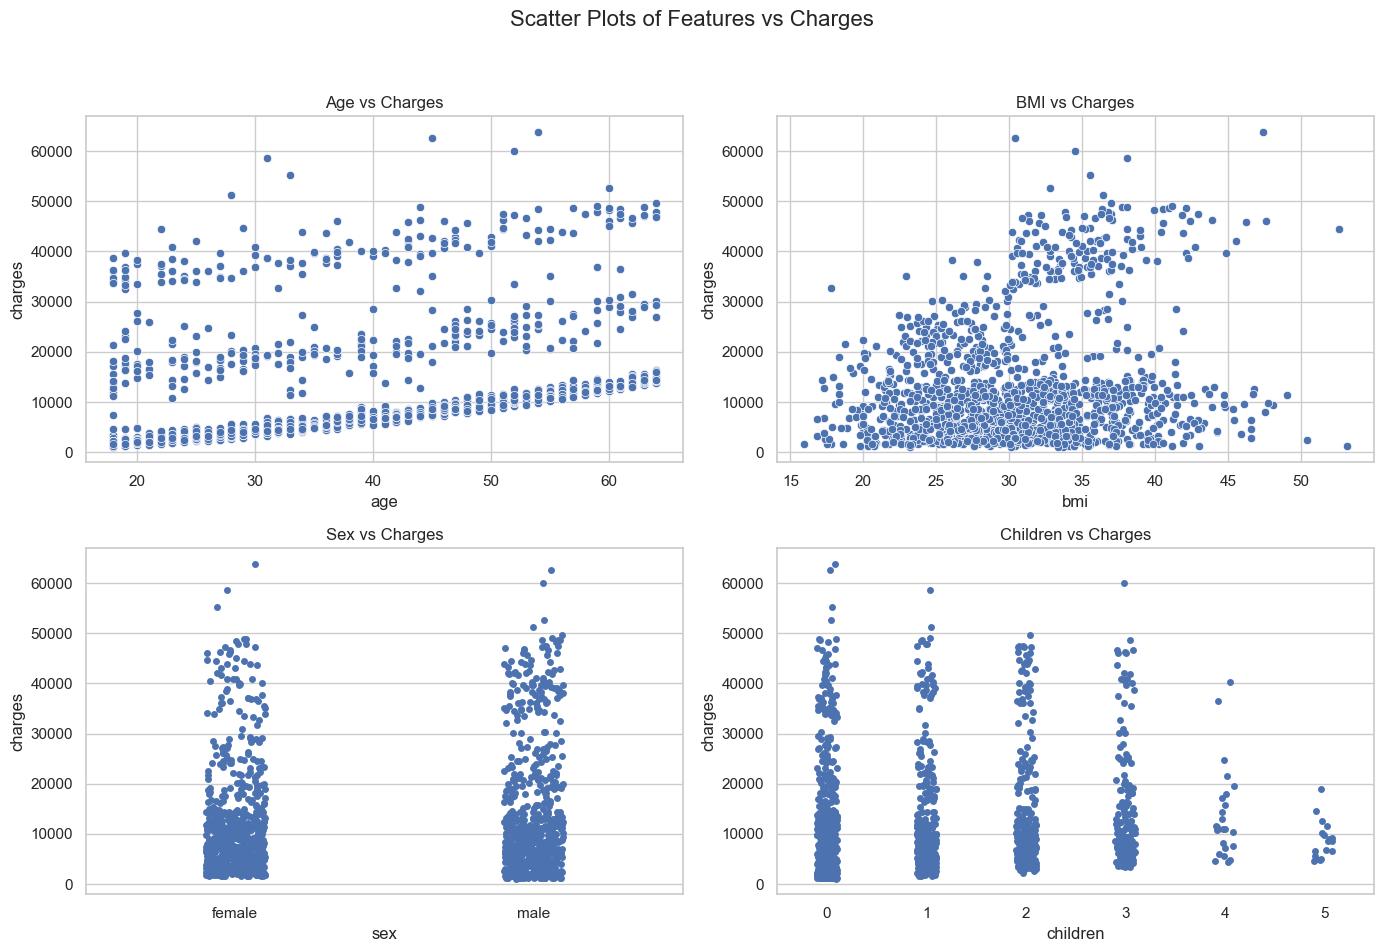

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Scatter Plots of Features vs Charges', fontsize=16)

# Age vs Charges
sns.scatterplot(x='age', y='charges', data=insurance_df, ax=axes[0, 0])
axes[0, 0].set_title('Age vs Charges')

# BMI vs Charges
sns.scatterplot(x='bmi', y='charges', data=insurance_df, ax=axes[0, 1])
axes[0, 1].set_title('BMI vs Charges')

# Sex vs Charges
sns.stripplot(x='sex', y='charges', data=insurance_df, ax=axes[1, 0])
axes[1, 0].set_title('Sex vs Charges')

# Children vs Charges
sns.stripplot(x='children', y='charges', data=insurance_df, ax=axes[1, 1])
axes[1, 1].set_title('Children vs Charges')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


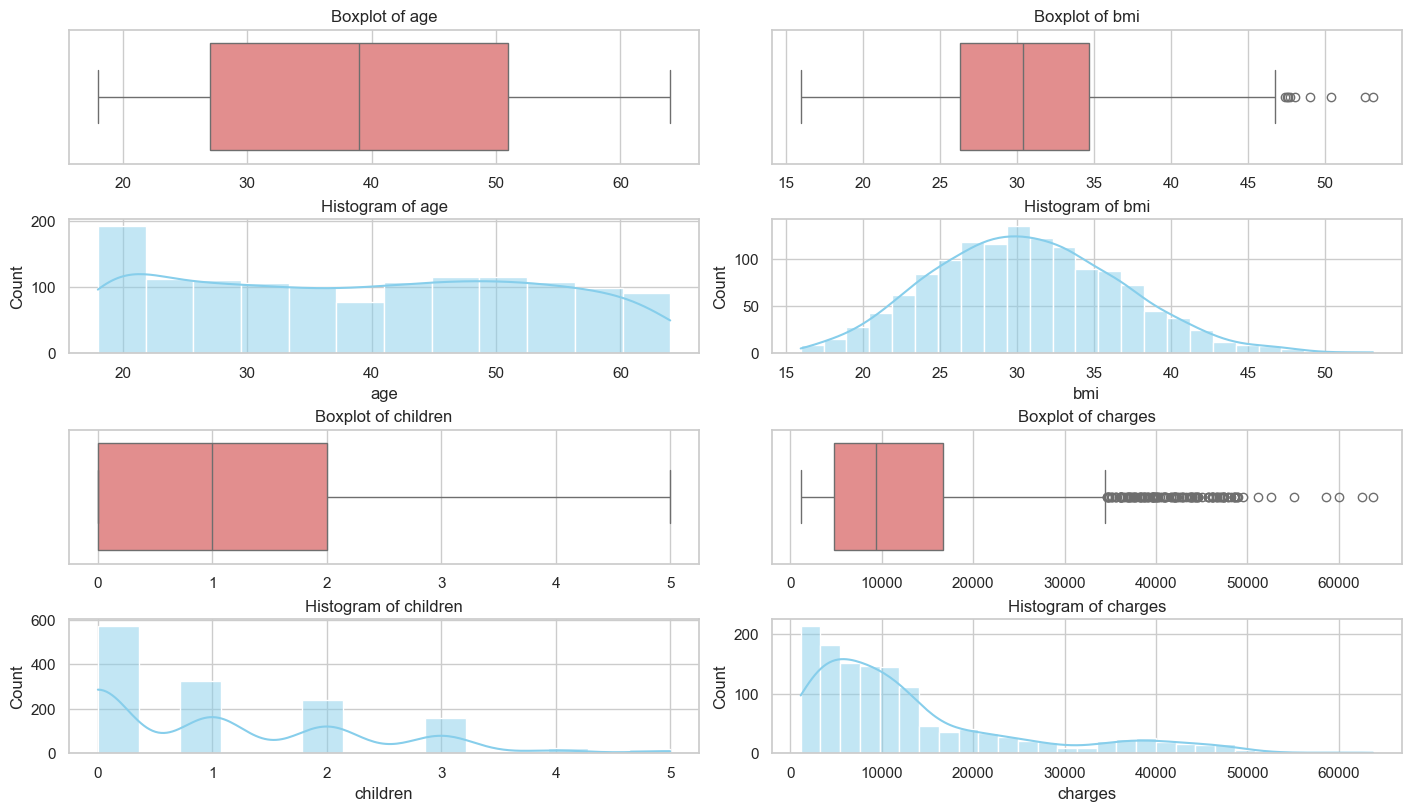

In [117]:

def plot_box_and_hist(dataframe, n_cols=2, figsize_base=(14, 4)):
    """
    Generates boxplots and histograms for all numeric columns in a DataFrame.

    Args:
        dataframe (pd.DataFrame): The input DataFrame.
        n_cols (int, optional): Number of columns in the subplot grid. Defaults to 2.
        figsize_base (tuple, optional): Base figure size (width, height).
            The height of the figure will be scaled based on the number of rows.
            Defaults to (14, 4).
    """
    numeric_columns = dataframe.select_dtypes(include='number').columns
    n_vars = len(numeric_columns)
    n_rows = math.ceil(n_vars / n_cols)

    fig, axs = plt.subplots(n_rows * 2, n_cols, figsize=(figsize_base[0], n_rows * figsize_base[1]), constrained_layout=True)

    for idx, col in enumerate(numeric_columns):
        row = (idx // n_cols) * 2
        col_pos = idx % n_cols

        sns.boxplot(x=dataframe[col], ax=axs[row][col_pos], color='lightcoral')
        axs[row][col_pos].set_title(f'Boxplot of {col}')
        axs[row][col_pos].set_xlabel('')

        sns.histplot(dataframe[col], kde=True, ax=axs[row + 1][col_pos], color='skyblue')
        axs[row + 1][col_pos].set_title(f'Histogram of {col}')
        axs[row + 1][col_pos].set_xlabel(col)

    # Hide any unused subplots
    total_plots = n_rows * n_cols
    for i in range(n_vars, total_plots):
        axs[(i // n_cols) * 2][i % n_cols].axis('off')
        axs[(i // n_cols) * 2 + 1][i % n_cols].axis('off')

    plt.show()


plot_box_and_hist(insurance_df)

In [120]:
Q1 = insurance_df['charges'].quantile(0.25)
Q3 = insurance_df['charges'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_charges = insurance_df[(insurance_df['charges'] < lower_bound) | (insurance_df['charges'] > upper_bound)]
print(f"Number of outliers: {len(outliers_charges)}", f" & shape of outliers: {outliers_charges.shape}")

print(f"Number of outliers: {len(insurance_df)}", f" & shape without outliers: {insurance_df.shape}")


Number of outliers: 139  & shape of outliers: (139, 7)
Number of outliers: 1337  & shape without outliers: (1337, 7)


In [122]:
Q1 = insurance_df['bmi'].quantile(0.25)
Q3 = insurance_df['bmi'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_bmi = insurance_df[(insurance_df['bmi'] < lower_bound) | (insurance_df['bmi'] > upper_bound)]
print(f"Number of outliers: {len(outliers_bmi)}")


Number of outliers: 9


In [124]:
# Replace outliers with the median charges
median_charges = insurance_df['charges'].median()
insurance_df['charges_imputed'] = np.where(insurance_df['charges'] > upper_bound, median_charges, 
                              np.where(insurance_df['charges'] < lower_bound, median_charges, insurance_df['charges']))
insurance_df['charges_imputed'] 

0       9386.1613
1       9386.1613
2       9386.1613
3       9386.1613
4       9386.1613
          ...    
1333    9386.1613
1334    9386.1613
1335    9386.1613
1336    9386.1613
1337    9386.1613
Name: charges_imputed, Length: 1337, dtype: float64

In [126]:
def check_skewness(df):
  
    skew_data = []

    numeric_cols = df.select_dtypes(include='number').columns

    for col in numeric_cols:
        skew_val = df[col].skew()
        if abs(skew_val) > 1:
            level = 'Highly skewed'
        elif abs(skew_val) > 0.5:
            level = 'Moderately skewed'
        else:
            level = 'Low skewness'
        skew_data.append({'Column': col, 'Skewness': round(skew_val, 3), 'Skewness Level': level})

    skew_df = pd.DataFrame(skew_data).sort_values(by='Skewness', key=lambda x: abs(x), ascending=False)
    #print(skew_df)
    return skew_df


In [128]:
check_skewness(insurance_df)

,Column,Skewness,Skewness Level
3,charges,1.515,Highly skewed
2,children,0.937,Moderately skewed
1,bmi,0.284,Low skewness
0,age,0.055,Low skewness
4,charges_imputed,0.000,Low skewness


In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox, skew

def compare_skewness_transformations(df, column):
    """
    Applies log, sqrt, cbrt, and boxcox transformations to a column
    and compares skewness. Also plots distributions.

    Parameters:
    df (pd.DataFrame): The dataset.
    column (str): The column name to transform.

    Returns:
    pd.Series: Skewness values for each transformation.
    """
    data = df[column].copy()
    
    # Remove non-positive values for applicable transformations
    data_positive = data[data > 0]

    transformed_data = {
        'Original': data,
        'Log': np.log(data_positive),
        'Sqrt': np.sqrt(data_positive),
        'Cbrt': np.cbrt(data),
        'Box-Cox': pd.Series(boxcox(data_positive)[0], index=data_positive.index)
    }

    # Calculate skewness
    skewness_results = {name: skew(values.dropna()) for name, values in transformed_data.items()}

    # Plotting
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for ax, (name, values) in zip(axes, transformed_data.items()):
        sns.histplot(values, bins=30, kde=True, ax=ax, color='skyblue')
        ax.set_title(f'{name}\nSkew: {skewness_results[name]:.2f}')
    plt.tight_layout()
    plt.show()

    return pd.Series(skewness_results).sort_values(key=lambda x: abs(x))


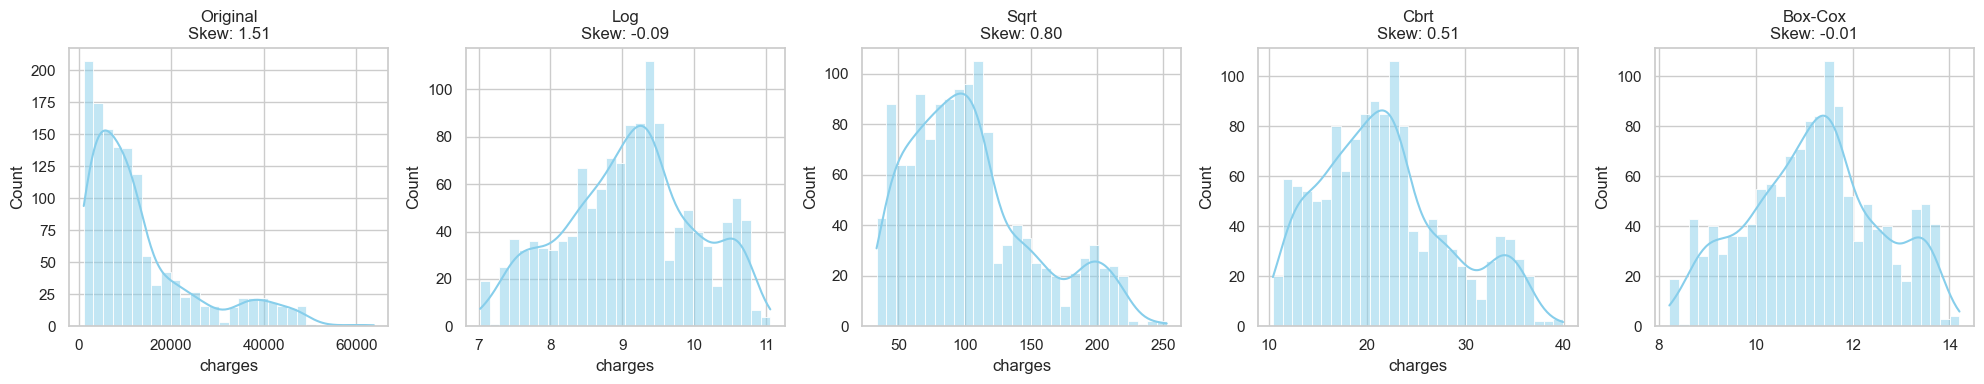

Box-Cox    -0.008665
Log        -0.089738
Cbrt        0.514901
Sqrt        0.795101
Original    1.513690
dtype: float64

In [136]:
compare_skewness_transformations(insurance_df, 'charges')

In [142]:
from scipy.stats import boxcox

# Ensure charges has only positive values for Box-Cox
charges_positive = insurance_df['charges'][insurance_df['charges'] > 0]

# Apply Box-Cox transformation
charges_boxcox_transformed, fitted_lambda = boxcox(charges_positive)

# Assign transformed values back to the original DataFrame
# Use the same index to align properly
insurance_df.loc[charges_positive.index, 'charges_boxcox'] = charges_boxcox_transformed


In [186]:
from scipy.stats import skew

print("Original Skewness:", skew(insurance_df['charges'].dropna()))
print("Box-Cox Skewness:", skew(insurance_df['charges_boxcox'].dropna()))


Original Skewness: 1.5136902413349014
Box-Cox Skewness: -0.008664562166442579


In [208]:
transformed_insurance_df = insurance_df
transformed_insurance_df

,age,sex,bmi,children,smoker,region,charges,charges_imputed,charges_boxcox
0,19,female,27.900,0,yes,southwest,16884.92400,9386.1613,12.120634
1,18,male,33.770,1,no,southeast,1725.55230,9386.1613,8.804026
2,28,male,33.000,3,no,southeast,4449.46200,9386.1613,10.141549
3,33,male,22.705,0,no,northwest,21984.47061,9386.1613,12.526076
4,32,male,28.880,0,no,northwest,3866.85520,9386.1613,9.939887
...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,9386.1613,11.416735
1334,18,female,31.920,0,no,northeast,2205.98080,9386.1613,9.145579
1335,18,female,36.850,0,no,southeast,1629.83350,9386.1613,8.725190
1336,21,female,25.800,0,no,southwest,2007.94500,9386.1613,9.014352


In [210]:
transformed_insurance_df = transformed_insurance_df.drop('charges', axis = 1)

In [212]:
transformed_insurance_df = transformed_insurance_df.rename(columns={'charges_boxcox':'charges'})

In [214]:
transformed_insurance_df = transformed_insurance_df.drop('charges_imputed', axis = 1)

In [216]:
transformed_insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,12.120634
1,18,male,33.770,1,no,southeast,8.804026
2,28,male,33.000,3,no,southeast,10.141549
3,33,male,22.705,0,no,northwest,12.526076
4,32,male,28.880,0,no,northwest,9.939887
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,11.416735
1334,18,female,31.920,0,no,northeast,9.145579
1335,18,female,36.850,0,no,southeast,8.725190
1336,21,female,25.800,0,no,southwest,9.014352


In [233]:
# Assuming `transformed_insurance_df` is your working DataFrame
encoded_df = pd.get_dummies(transformed_insurance_df, columns=['sex', 'smoker','region'], drop_first=True)

# View the result
encoded_df


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,12.120634,False,True,False,False,True
1,18,33.770,1,8.804026,True,False,False,True,False
2,28,33.000,3,10.141549,True,False,False,True,False
3,33,22.705,0,12.526076,True,False,True,False,False
4,32,28.880,0,9.939887,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,11.416735,True,False,True,False,False
1334,18,31.920,0,9.145579,False,False,False,False,False
1335,18,36.850,0,8.725190,False,False,False,True,False
1336,21,25.800,0,9.014352,False,False,False,False,True


In [235]:
# Assuming 'price' is your target
X = encoded_df.drop('charges', axis=1)
y = encoded_df['charges']

# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)


In [237]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [239]:
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(pd.DataFrame(y_train))
y_test_scaled = scaler.transform(pd.DataFrame(y_test))


In [241]:
# Building the models
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
# Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train_scaled)
y_pred_train_lr = linear_model.predict(X_train_scaled)
y_pred_test_lr = linear_model.predict(X_test_scaled)

In [243]:
print("Accuracy Scores for Linear Regression model ")
lr_rmse_train = mean_squared_error(y_test_scaled, y_pred_test_lr)
lr_rmse_test = mean_squared_error(y_train_scaled, y_pred_train_lr)
lr_r2s_train = r2_score(y_train_scaled, y_pred_train_lr)
lr_r2s_test = r2_score(y_test_scaled, y_pred_test_lr)
print("Mean Squared Error :", lr_rmse_train)
print("Mean Squared Error :", lr_rmse_train)
print("R-squared Score (Train) :", lr_r2s_train)
print("R-squared Score (Test) :", lr_r2s_test)
print("**************" * 7)

Accuracy Scores for Linear Regression model 
Mean Squared Error : 0.1894784114009047
Mean Squared Error : 0.1894784114009047
R-squared Score (Train) : 0.7493945955247094
R-squared Score (Test) : 0.8268188199995472
**************************************************************************************************


In [245]:
lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train_scaled)
y_pred_train_lar = lasso_model.predict(X_train_scaled)
y_pred_test_lar = lasso_model.predict(X_test_scaled)

print("Accuracy Scores for Lasso Regression (L1 Regularization) model ")
train_lar_rmse = mean_squared_error(y_train_scaled, y_pred_train_lar)
test_lar_rmse = mean_squared_error(y_test_scaled, y_pred_test_lar)
train_lar_r2s = r2_score(y_train_scaled, y_pred_train_lar)
test_lar_r2s = r2_score(y_test_scaled, y_pred_test_lar)
print("Mean Squared Error :", train_lar_rmse)
print("Mean Squared Error :", test_lar_rmse)
print("R-squared Score (Train) :", train_lar_r2s)
print("R-squared Score (Test) :", test_lar_r2s)
print("**************" * 7)

Accuracy Scores for Lasso Regression (L1 Regularization) model 
Mean Squared Error : 1.0
Mean Squared Error : 1.094691716431648
R-squared Score (Train) : 0.0
R-squared Score (Test) : -0.0005361655013780275
**************************************************************************************************


In [247]:
# Ridge Regression (L2 Regularization)
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train_scaled)
y_pred_train_ridge = ridge_model.predict(X_train_scaled)
y_pred_test_ridge = ridge_model.predict(X_test_scaled)

print("Accuracy Scores for Ridge Regression (L2 Regularization) model")
train_ridge_rmse = mean_squared_error(y_train_scaled, y_pred_train_ridge)
test_ridge_rmse = mean_squared_error(y_test_scaled, y_pred_test_ridge)
train_ridge_r2s = r2_score(y_train_scaled, y_pred_train_ridge)
test_ridge_r2s = r2_score(y_test_scaled, y_pred_test_ridge)
print("Mean Squared Error :", train_ridge_rmse)
print("Mean Squared Error :", test_ridge_rmse)
print("R-squared Score (Train) :", train_ridge_r2s)
print("R-squared Score (Test) :", test_ridge_r2s)
print("**************" * 7)

Accuracy Scores for Ridge Regression (L2 Regularization) model
Mean Squared Error : 0.2506062094431423
Mean Squared Error : 0.18958765244584827
R-squared Score (Train) : 0.7493937905568577
R-squared Score (Test) : 0.8267189748882866
**************************************************************************************************


In [249]:
# Elastic Net Regression (L1 and L2 Regularizations)
enet_model = ElasticNet()
enet_model.fit(X_train_scaled, y_train_scaled)
y_pred_train_enet = enet_model.predict(X_train_scaled)
y_pred_test_enet = enet_model.predict(X_test_scaled)

print("Accuracy Scores for Elastic Net Regression (L1 and L2 Regularizations) model")
train_enet_rmse = mean_squared_error(y_train_scaled, y_pred_train_enet)
test_enet_rmse = mean_squared_error(y_test_scaled, y_pred_test_enet)
train_enet_r2s = r2_score(y_train_scaled, y_pred_train_enet)
test_enet_r2s = r2_score(y_test_scaled, y_pred_test_enet)
print("Mean Squared Error :", train_enet_rmse)
print("Mean Squared Error :", test_enet_rmse)
print("R-squared Score (Train) :", train_enet_r2s)
print("R-squared Score (Test) :", test_enet_r2s)
print("**************" * 7)

Accuracy Scores for Elastic Net Regression (L1 and L2 Regularizations) model
Mean Squared Error : 0.8617150514968033
Mean Squared Error : 0.9414381354259077
R-squared Score (Train) : 0.13828494850319673
R-squared Score (Test) : 0.13953591870938464
**************************************************************************************************


In [251]:
# Decission Tree regression - Choosing max depth as 6 after trying different values
dtree = DecisionTreeRegressor(max_depth = 6)
dtree.fit(X_train_scaled, y_train_scaled)
y_pred_train_dtree = dtree.predict(X_train_scaled)
y_pred_test_dtree = dtree.predict(X_test_scaled)

print("Accuracy Scores for Decision Tree model ")
train_dtree_rmse = mean_squared_error(y_train_scaled, y_pred_train_dtree)
test_dtree_rmse = mean_squared_error(y_test_scaled, y_pred_test_dtree)
train_dtree_r2s = r2_score(y_train_scaled, y_pred_train_dtree)
test_dtree_r2s = r2_score(y_test_scaled, y_pred_test_dtree)
print("Mean Squared Error :", train_dtree_rmse)
print("Mean Squared Error :", test_dtree_rmse)
print("R-squared Score (Train) :", train_dtree_r2s)
print("R-squared Score (Test) :", test_dtree_r2s)
print("**************" * 7)

Accuracy Scores for Decision Tree model 
Mean Squared Error : 0.14064386634863515
Mean Squared Error : 0.16107382453073185
R-squared Score (Train) : 0.8593561336513649
R-squared Score (Test) : 0.852780299385153
**************************************************************************************************


In [253]:
# Random Forest regression - Choosing max depth as 6 after trying different values
# Choosing the parameters after trying different values
rf_raw = RandomForestRegressor(n_estimators = 500, random_state = 1, max_depth = 6)
rf_raw.fit(X_train_scaled, y_train_scaled.ravel())
y_pred_train_rf = rf_raw.predict(X_train_scaled)
y_pred_test_rf = rf_raw.predict(X_test_scaled)

print("Accuracy Scores for Random Forest model ")
train_rf_rmse = mean_squared_error(y_train_scaled, y_pred_train_rf)
test_rf_rmse = mean_squared_error(y_test_scaled, y_pred_test_rf)
train_rf_r2s = r2_score(y_train_scaled, y_pred_train_rf)
test_rf_r2s = r2_score(y_test_scaled, y_pred_test_rf)
print("Mean Squared Error :", train_rf_rmse)
print("Mean Squared Error :", test_rf_rmse)
print("R-squared Score (Train) :", train_rf_r2s)
print("R-squared Score (Test) :", test_rf_r2s)
print("**************" * 7)

Accuracy Scores for Random Forest model 
Mean Squared Error : 0.12673224539664454
Mean Squared Error : 0.14226739460511595
R-squared Score (Train) : 0.8732677546033555
R-squared Score (Test) : 0.8699691690934961
**************************************************************************************************


In [255]:
# Gradient Boosting Regression model
gb_raw = GradientBoostingRegressor(n_estimators = 100, max_depth = 3, random_state = 42)
gb_raw.fit(X_train_scaled, y_train_scaled.ravel())
y_pred_train_gb = gb_raw.predict(X_train_scaled)
y_pred_test_gb = gb_raw.predict(X_test_scaled)

print("Accuracy Scores for Gradient Boost Regressor model on raw data")
train_gb_rmse = mean_squared_error(y_train_scaled, y_pred_train_gb)
test_gb_rmse = mean_squared_error(y_test_scaled, y_pred_test_gb)
train_gb_r2s = r2_score(y_train_scaled, y_pred_train_gb)
test_gb_r2s = r2_score(y_test_scaled, y_pred_test_gb)
print("Mean Squared Error :", train_gb_rmse)
print("Mean Squared Error :", test_gb_rmse)
print("R-squared Score (Train) :", train_gb_r2s)
print("R-squared Score (Test) :", test_gb_r2s)
print("**************" * 7)

Accuracy Scores for Gradient Boost Regressor model on raw data
Mean Squared Error : 0.12799280255324091
Mean Squared Error : 0.13515162298749872
R-squared Score (Train) : 0.8720071974467591
R-squared Score (Test) : 0.8764729059374012
**************************************************************************************************


In [257]:
# XGBoost Regression model - Max depth = 2 after testing various values
xgb_raw = xgb.XGBRegressor(random_state = 111, max_depth = 2)
xgb_raw.fit(X_train_scaled, y_train_scaled)
y_pred_train_xgb = xgb_raw.predict(X_train_scaled)
y_pred_test_xgb = xgb_raw.predict(X_test_scaled)

print("Accuracy Scores for XGBoost model on raw data")
train_xgb_rmse = mean_squared_error(y_train_scaled, y_pred_train_xgb)
test_xgb_rmse = mean_squared_error(y_test_scaled, y_pred_test_xgb)
train_xgb_r2s = r2_score(y_train_scaled, y_pred_train_xgb)
test_xgb_r2s = r2_score(y_test_scaled, y_pred_test_xgb)
print("Mean Squared Error :", train_xgb_rmse)
print("Mean Squared Error :", test_xgb_rmse)
print("R-squared Score (Train) :", train_xgb_r2s)
print("R-squared Score (Test) :", test_xgb_r2s)
print("**************" * 7)

Accuracy Scores for XGBoost model on raw data
Mean Squared Error : 0.1399459913538712
Mean Squared Error : 0.14010533433463304
R-squared Score (Train) : 0.8600540086461288
R-squared Score (Test) : 0.8719452683551798
**************************************************************************************************


In [280]:
# Support Vector Regression model - Poly kernel
svr_poly_raw = SVR(kernel = 'poly')
svr_poly_raw.fit(X_train_scaled, y_train_scaled)
y_pred_train_svr_poly = svr_poly_raw.predict(X_train_scaled)
y_pred_test_svr_poly = svr_poly_raw.predict(X_test_scaled)

print("Accuracy Scores for Support Vector Model with poly kernel on raw data")
train_svr_poly_rmse = mean_squared_error(y_train_scaled, y_pred_train_svr_poly)
test_svr_poly_rmse = mean_squared_error(y_test_scaled, y_pred_test_svr_poly)
train_svr_poly_r2s = r2_score(y_train_scaled, y_pred_train_svr_poly)
test_svr_poly_r2s = r2_score(y_test_scaled, y_pred_test_svr_poly)
print("Root Mean Squared Error :", train_svr_poly_r2s)
print("Root Mean Squared Error :", test_svr_poly_rmse)
print("R-squared Score (Train) :", train_svr_poly_r2s)
print("R-squared Score (Test) :", test_svr_poly_r2s)
print("**************" * 7)

Accuracy Scores for Support Vector Model with poly kernel on raw data
Root Mean Squared Error : 0.8104070062218307
Root Mean Squared Error : 0.14690178464281817
R-squared Score (Train) : 0.8104070062218307
R-squared Score (Test) : 0.8657333876692288
**************************************************************************************************


In [282]:
# Building KNN regressor with k = 2
knn_raw = KNeighborsRegressor(n_neighbors = 3)
knn_raw.fit(X_train_scaled, y_train_scaled)
y_pred_train_knn = knn_raw.predict(X_train_scaled)
y_pred_test_knn = knn_raw.predict(X_test_scaled)

print("Accuracy Scores for KNN Regressor model on raw data")
train_knn_rmse = mean_squared_error(y_pred_train_knn, y_pred_train_knn)
test_knn_rmse = mean_squared_error(y_test_scaled, y_pred_test_knn)
train_knn_r2s = r2_score(y_pred_train_knn, y_pred_train_knn)
test_knn_r2s = r2_score(y_test_scaled, y_pred_test_knn)
print("Mean Squared Error :", train_knn_rmse)
print("Mean Squared Error :", test_knn_rmse)
print("R-squared Score (Train) :", train_knn_r2s)
print("R-squared Score (Test) :", test_knn_r2s)
print("**************" * 7)

Accuracy Scores for KNN Regressor model on raw data
Mean Squared Error : 0.0
Mean Squared Error : 0.20061304878792713
R-squared Score (Train) : 1.0
R-squared Score (Test) : 0.8166418841296252
**************************************************************************************************


##### 